# Speech recognition
As a part of Kaggle challange: https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/

1. Load files

Prepare:
2. Resampling (or not?)
3. Silence reduction
4. Normalize
5. Complete to 1 second
6. Log spectrogram
7. PCA

Train


In [3]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

In [189]:
train_audio_path = 'C:/Users/egorc/Documents/Datasets/tf_speech_recognition/train/audio/'
filename = 'yes/0ac15fe9_nohash_0.wav'
sample_rate, samples = wavfile.read(train_audio_path + filename)
print(samples.shape)

(16000,)


array([558, 709,  85, ..., 276, 323, 643], dtype=int16)

## Spectrogram

In [21]:
def log_spectrogram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size*sample_rate/1000))
    noverlap = int(round(step_size*sample_rate/1000))
    freqs, times, spec = signal.spectrogram(audio,
                                           fs=sample_rate,
                                           window='hann',
                                           nperseg=nperseg,
                                           noverlap=noverlap,
                                           detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

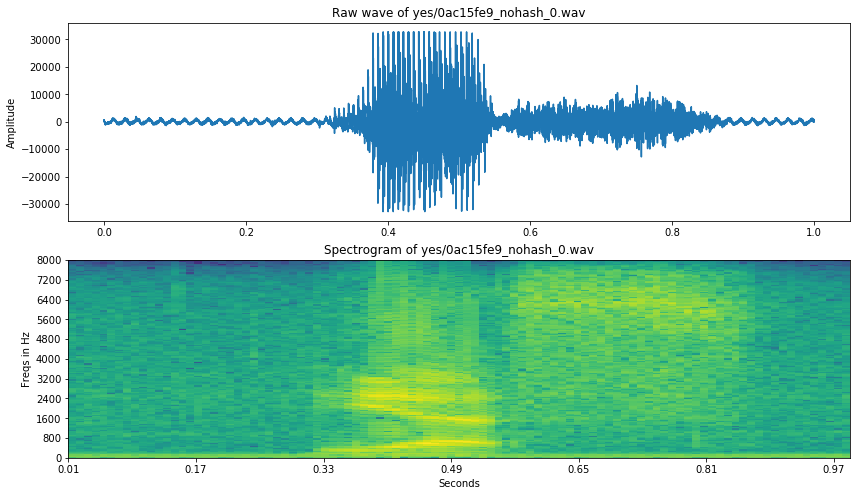

In [22]:
fr, time, spec = log_spectrogram(samples, sample_rate)

fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spec.T, aspect='auto', origin='lower',
          extent=[time.min(), time.max(), fr.min(), fr.max()])
ax2.set_yticks(fr[::16])
ax2.set_xticks(time[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [26]:
mean = np.mean(spec, axis=0)
std = np.std(spec, axis=0)
spectrogram = (spec - mean) / std # Do this over all dataset

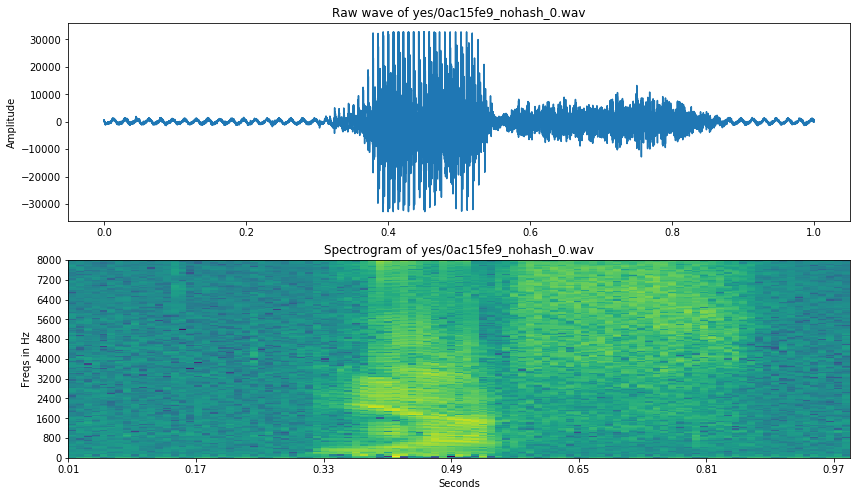

In [30]:
fig = plt.figure(figsize=(14,8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
          extent=[time.min(), time.max(), fr.min(), fr.max()])
ax2.set_yticks(fr[::16])
ax2.set_xticks(time[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

## Mel power spectrogram

C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\librosa\display.py:656: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.



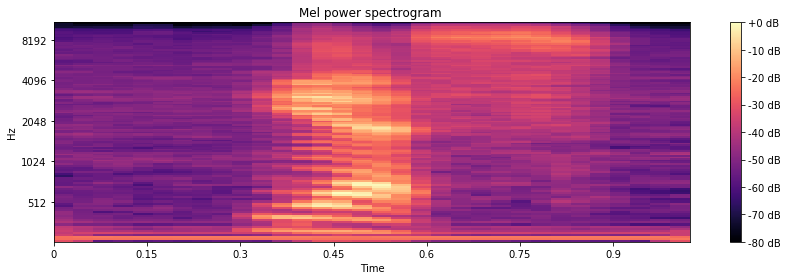

In [31]:
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

C:\Users\egorc\AppData\Local\conda\conda\envs\ipythonenv\lib\site-packages\librosa\display.py:656: FutureWarning:

Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.



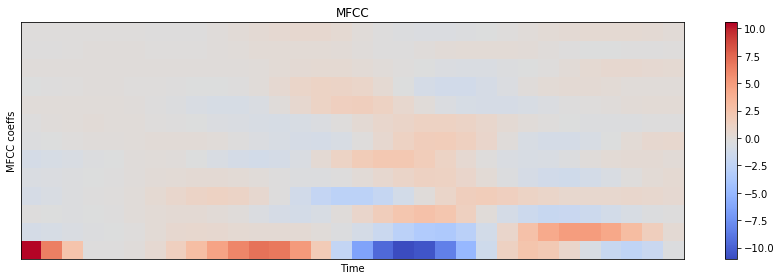

In [32]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

## Silence removal
#TODO: use webrtcvad to remove silence in the beginning and at end

In [33]:
ipd.Audio(samples, rate=sample_rate)

In [34]:
ipd.Audio(samples[4800:14400], rate=sample_rate)

## Resampling

In [35]:
def fast_fourier_tf(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])
    return xf, vals

In [167]:
new_sample_rate = 8000
samples_resampled = signal.resample(samples, int(new_sample_rate/sample_rate*samples.shape[0]))

AttributeError: 'int' object has no attribute 'shape'

In [166]:
int(new_sample_rate/sample_rate*samples.shape[0])

AttributeError: 'int' object has no attribute 'shape'

In [37]:
ipd.Audio(samples, rate=sample_rate)

In [38]:
ipd.Audio(samples_resampled, rate=new_sample_rate)

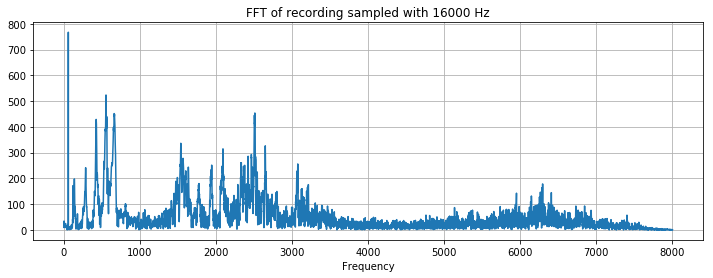

In [40]:
xf, vals = fast_fourier_tf(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

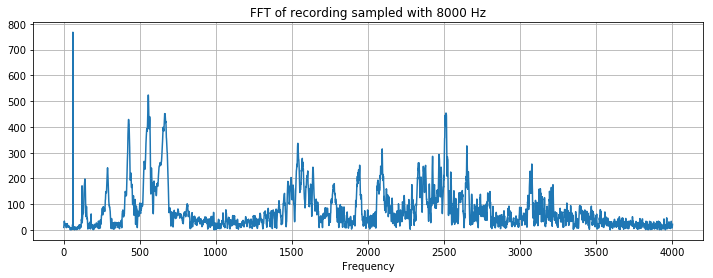

In [42]:
xf, vals = fast_fourier_tf(samples_resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show()

# Train

In [76]:
import wave
import contextlib


# Break silence in pieces
noise_dir = './Documents/Datasets/tf_speech_recognition/train/audio/_background_noise_/'
dest_dir = './Documents/Datasets/tf_speech_recognition/train/audio/noise/'
counter = 0
files_in_dir = [x[2] for x in os.walk(noise_dir)]

for file_name in files_in_dir[0]:
    print(file_name)
    file_path = noise_dir + file_name
    with contextlib.closing(wave.open(file_path, 'rb')) as f:
        num_channels = f.getnchannels()
        assert num_channels == 1
        sample_width = f.getsampwidth()
        assert sample_width == 2
        samples = f.getframerate()
        assert samples == 16000
        pcm_data = f.readframes(f.getnframes())
    
    chunks = []
    offset = 0
    step = 16000
    while offset < len(pcm_data):
        if len(pcm_data)-offset < step:
            chunks.append(pcm_data[offset:len(pcm_data)])
        chunks.append(pcm_data[offset:offset+step])
        offset += step
    
    
    for i, chunk in enumerate(chunks):
        path = dest_dir + 'chunk-0%005d.wav' % (counter + i)
        with contextlib.closing(wave.open(path, 'wb')) as wf:
            wf.setnchannels(1)
            wf.setsampwidth(2)
            wf.setframerate(sample_rate)
            wf.writeframes(chunk)
        counter += 1

doing_the_dishes.wav
dude_miaowing.wav
exercise_bike.wav
pink_noise.wav
running_tap.wav
silence.wav
silence2.wav
white_noise.wav


In [92]:
# moving validation and test files to another directory
root_dir = './Documents/Datasets/tf_speech_recognition/train/'
audio_dir = 'audio/'
val_dir = 'validation/'
test_dir = 'test/'
validation_files = []
testing_files = []
with open(root_dir + 'validation_list.txt', 'r') as f:
    validation_files = f.read().split('\n')
with open(root_dir + 'testing_list.txt', 'r') as f:
    testing_files = f.read().split('\n')
    
for f in validation_files:
    m = re.match(r'([a-z]+)\/([A-Za-z0-9]+)_\w+', f)
    if not os.path.exists(root_dir + val_dir + m.group(1)):
        os.makedirs(root_dir + val_dir + m.group(1))
    os.rename(root_dir + audio_dir + f, root_dir + val_dir + f)
for f in testing_files[:-1]:
    m = re.match(r'([a-z]+)\/([A-Za-z0-9]+)_\w+', f)
    if not os.path.exists(root_dir + test_dir + m.group(1)):
        os.makedirs(root_dir + test_dir + m.group(1))
    os.rename(root_dir + audio_dir + f, root_dir + test_dir + f)

In [102]:
if done:
    return

import random

noise_path = './Documents/Datasets/tf_speech_recognition/train/audio/noise/'

noise_files = [x[2] for x in os.walk(noise_path)][0]
val_noise = random.sample(noise_files, 340)

for f in val_noise:
    if not os.path.exists(root_dir + val_dir + 'noise/'):
        os.makedirs(root_dir + val_dir + 'noise/')
    os.rename(root_dir + audio_dir + 'noise/' + f, root_dir + val_dir + 'noise/' + f)
    
noise_files = [x[2] for x in os.walk(noise_path)][0]
test_noise = random.sample(noise_files, 340)

for f in test_noise:
    if not os.path.exists(root_dir + test_dir + 'noise/'):
        os.makedirs(root_dir + test_dir + 'noise/')
    os.rename(root_dir + audio_dir + 'noise/' + f, root_dir + test_dir + 'noise/' + f)

In [431]:
# Reading files in memory
def create_data_dict(path):
    result = []
    for p in [x[1] for x in os.walk(path)][0]:
        class_label = p
        for f in [x[2] for x in os.walk(path + p + '/')][0]:
            train_sample_rate, train_samples = wavfile.read(path + p + '/' + f)
            result = np.append(result, {'y':p, 'x':train_samples})
        print('Processed class: ' + p)
    return result
    
train_audio_path = './Documents/Datasets/tf_speech_recognition/train/audio/'
train_data = create_data_dict(train_audio_path)
validation_audio_path = './Documents/Datasets/tf_speech_recognition/train/validation/'
validation_data = create_data_dict(validation_audio_path)

Processed class: bed
Processed class: bird
Processed class: cat
Processed class: dog
Processed class: down
Processed class: eight
Processed class: five
Processed class: four
Processed class: go
Processed class: happy
Processed class: house
Processed class: left
Processed class: marvin
Processed class: nine
Processed class: no
Processed class: noise
Processed class: off
Processed class: on
Processed class: one
Processed class: right
Processed class: seven
Processed class: sheila
Processed class: six
Processed class: stop
Processed class: three
Processed class: tree
Processed class: two
Processed class: up
Processed class: wow
Processed class: yes
Processed class: zero


# Preparation pipeline

2. Resampling (or not?) + 
3. Silence reduction -
4. Normalize +
5. Complete to 1 second +?
6. Log spectrogram + 
7. PCA -

In [448]:
new_sample_rate = 8000
sample_rate = 16000

def resample(data, col, old_sr, new_sr):
    result = []
    for i in range(data.shape[0]):
        audio_wave = data[i][col]
        result.append(signal.resample(audio_wave, int(new_sr/old_sr*audio_wave.shape[0])))
    return result

np.random.shuffle(train_data)
x_train = resample(train_data, 'x', sample_rate, new_sample_rate)
np.random.shuffle(validation_data)
x_validation = resample(validation_data, 'x', sample_rate, new_sample_rate)

In [449]:
def count_with_length_lt(data, sr):
    non_format = 0
    for i in data:
        if i.shape[0] < sr:
            non_format += 1
    print(non_format) # Total leaking bits  
    
count_with_length_lt(x_train, new_sample_rate)
count_with_length_lt(x_validation, new_sample_rate)

7929
1001


In [450]:
def append_to_1_sec(data, sr):
    for i in range(len(data)):
        f_length = data[i].shape[0]
        if f_length != sr:
            len_dif = sr - f_length
            start_bytes = int(len_dif/2)
            end_bytes = len_dif - start_bytes
            start_zeros = np.zeros(start_bytes)
            end_zeros = np.zeros(end_bytes)
            data[i] = np.concatenate((start_zeros, data[i], end_zeros))
    return data

x_train = append_to_1_sec(x_train, new_sample_rate)
x_validation = append_to_1_sec(x_validation, new_sample_rate)

In [451]:
def extract_labels(data, column):
    result = []
    for i in range(data.shape[0]):
        result.append(data[i][column])
    return result
    
y_train = extract_labels(train_data, 'y')
y_validation = extract_labels(validation_data, 'y')

In [438]:
ipd.Audio(x_validation[1400], rate=new_sample_rate)

In [452]:
def build_log_specgram(data, sr):
    for i in range(len(data)):
        S_train = librosa.feature.melspectrogram(data[i], sr=sr, n_mels=128)
        log_S_train = librosa.power_to_db(S_train, ref=np.max)
        data[i] = log_S_train
    return data

x_train = build_log_specgram(x_train, new_sample_rate) 
x_validation = build_log_specgram(x_validation, new_sample_rate) 

In [454]:
def standardize(data):
    mean = np.mean(data)
    std = np.std(data)
    result = []
    for i in range(len(data)):
        result.append((data[i] - mean)/std)
    return result
        
x_train_std = standardize(x_train)
x_validation_std = standardize(x_validation)

In [456]:
def dataset_to_type(data, new_type):
    for i in range(len(data)):
        data[i] = data[i].astype(new_type)
    return data

x_train_std = dataset_to_type(x_train_std, np.float32)
x_validation_std = dataset_to_type(x_validation_std, np.float32)

In [466]:
import pickle
import math
import matplotlib.pyplot as plt
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D

class CNN_classifier:
    def __init__(self, im_h, im_w):
        self.h = im_h
        self.w = im_w
        
    def load_data(self, data=None, labels=None, test_data=None, test_labels=None, load=False, model_only=False):
        if load:
            self.__load_model(model_only) 
        elif data.any() and labels.any():
            self.data = data
            self.labels = labels
            self.test_data = test_data
            self.test_labels = test_labels
        else:
            raise ValueError
        
    def fit(self, batch_size=32, epoch=10, verbose=1):
        self.model = self.__compile_cnn()
        self.model, self.history = self.__train_cnn(self.model, batch_size, epoch, verbose)
        pickle.dump(self.history,
                    open('history.pkl', 'wb'),
                    protocol=4)
        
    def __compile_cnn(self):
        K.set_image_dim_ordering('th') # th - Theano input (channel,size_lines,size_columns), 
                                        # tf - Tensorflow input (size_lines,size_columns,channel)
        model = Sequential()
        model.add(Convolution2D(20,(5,5),activation='relu',input_shape=(1,self.h,self.w)))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Convolution2D(40,(5,5),activation='relu'))
        model.add(MaxPooling2D(pool_size=(2,2)))
        model.add(Flatten())
        model.add(Dense(400,activation='relu'))
        model.add(Dense(200,activation='relu'))
        model.add(Dropout(0.4))      
        model.add(Dense(12,activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model
    
    def __train_cnn(self, model, batch_size, epoch, verbose):
        hist = model.fit(self.data, self.labels, batch_size, epoch, verbose)
        return (model, hist)
    
    def evaluate(self, verbose=1):
        if not self.test_data.any() or not self.test_labels.any():
            raise ValueError
        self.score = self.model.evaluate(self.test_data, self.test_labels, verbose)
        print(f'\nLoss: {self.score[0]}\nAccuracy: {self.score[1]*100:.2f}%')
    
    def predict(self, pred_data, verbose=1):
        pred = self.model.predict(pred_data, verbose)
        return pred
    
    def save_model(self, model_only=False):
        pickle.dump(self.model,
                    open('model.pkl', 'wb'),
                    protocol=4)
        if not model_only:
            pickle.dump(self.labels,
                        open('y_train.pkl', 'wb'),
                        protocol=4)
            pickle.dump(self.test_labels,
                        open('y_test.pkl', 'wb'),
                        protocol=4)
            pickle.dump(self.test_data,
                        open('X_test.pkl', 'wb'),
                        protocol=4)
            pickle.dump(self.data,
                        open('X_train.pkl', 'wb'),
                        protocol=4)
        
    def __load_model(self, model_only=False):
        self.model = pickle.load(open('model.pkl', 'rb'))
        if not model_only:
            self.labels = pickle.load(open('y_train.pkl', 'rb'))
            self.test_labels = pickle.load(open('y_test.pkl', 'rb'))
            self.data = pickle.load(open('X_train.pkl', 'rb'))
            self.test_data = pickle.load(open('X_test.pkl', 'rb'))

In [458]:
labels = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']

def encode_labels(labs):
    result = []
    for i in range(len(labs)):
        vector = np.zeros(12)
        if labs[i] in labels:
            vector[labels.index(labs[i])] = 1.
        else:
            vector[10] = 1. # unknown
        vector = vector.astype(np.float32)
        result.append(vector)
    return result
        
def decode_labels(vect):
    return labels[np.argmax(vect)]

In [464]:
classifier = CNN_classifier(128, 16)
x_train_std_np = np.array(x_train_std).reshape(-1, 1, 128, 16)
y_oh_train = np.array(encode_labels(y_train))
classifier.load_data(data=x_train_std_np, labels=y_oh_train)
classifier.fit(epoch=15)

Epoch 1/15
53813/53813 [==============================] - 50s - loss: 0.9116 - acc: 0.7226    
Epoch 2/15
53813/53813 [==============================] - 50s - loss: 0.4852 - acc: 0.8424    
Epoch 3/15
53813/53813 [==============================] - 49s - loss: 0.3697 - acc: 0.8805    
Epoch 4/15
53813/53813 [==============================] - 49s - loss: 0.3057 - acc: 0.8991    
Epoch 5/15
53813/53813 [==============================] - 50s - loss: 0.2686 - acc: 0.9127    
Epoch 6/15
53813/53813 [==============================] - 50s - loss: 0.2364 - acc: 0.9231    
Epoch 7/15
53813/53813 [==============================] - 50s - loss: 0.2125 - acc: 0.9303    
Epoch 8/15
53813/53813 [==============================] - 50s - loss: 0.1883 - acc: 0.9384    
Epoch 9/15
53813/53813 [==============================] - 50s - loss: 0.1719 - acc: 0.9434    
Epoch 10/15
53813/53813 [==============================] - 50s - loss: 0.1556 - acc: 0.9481    
Epoch 11/15
53813/53813 [========================

In [465]:
classifier.test_data = np.array(x_validation_std).reshape(-1, 1, 128, 16)
classifier.test_labels = np.array(encode_labels(y_validation))
classifier.evaluate()

7138/7138 [==============================] - 18s    
Loss: 0.5052341261698954
Accuracy: 89.80%


In [505]:
print(labels[np.argmax(classifier.predict(classifier.test_data[23].reshape(-1, 1, 128, 16)))])
ipd.Audio(validation_data[23]['x'], rate=sample_rate)

yes


In [529]:


def process_test_files(path, num_test_files, clsfier, output_results, batch_size=10000):
    files_offset = 0
    while True: 
        if files_offset >= num_test_files: # Number of test files
            break
        test_data = get_test_list(path, files_offset, files_offset+batch_size)
        files_offset += batch_size
        if (files_offset + batch_size) > num_test_files:
            batch_size = num_test_files - files_offset
        x_test_part = resample(test_data, 'x', sample_rate, new_sample_rate)
        x_test_part = append_to_1_sec(x_test_part, new_sample_rate)
        x_test_part = build_log_specgram(x_test_part, new_sample_rate) 
        x_test_part_std = standardize(x_test_part)
        x_test_part_std = dataset_to_type(x_test_part_std, np.float32)
        test_fname = extract_labels(test_data, 'y')
        # Predicting
        for i in range(len(x_test_part_std)):
            pred_proba = clsfier.predict(x_test_part_std[i].reshape(-1, 1, 128, 16))
            lbl = labels[np.argmax(pred_proba)]
            output_results = output_results.append({'fname':test_fname[i],'label':lbl}, ignore_index=True)
        print('Samples predicted: ' + str(files_offset))
    return output_results
        
        
def get_test_list(path, files_offset, batch_size):
    result = []
    for f in [x[2] for x in os.walk(path)][0][files_offset:batch_size]:
        train_sample_rate, train_samples = wavfile.read(path + f)
        result = np.append(result, {'x':train_samples, 'y':f})
    return result
    
# Generating output and testing on unseen data
test_audio_path = './Documents/Datasets/tf_speech_recognition/test/audio/'
output_res = pd.DataFrame()
test_df = process_test_files(test_audio_path, 158538, classifier, output_res)

Samples predicted: 10000
Samples predicted: 20000
Samples predicted: 30000
Samples predicted: 40000
Samples predicted: 50000
Samples predicted: 60000
Samples predicted: 70000
Samples predicted: 80000
Samples predicted: 90000
Samples predicted: 100000
Samples predicted: 110000
Samples predicted: 120000
Samples predicted: 130000
Samples predicted: 140000
Samples predicted: 150000
Samples predicted: 158538


In [533]:
test_df.to_csv('submission.csv',index=False)